In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
test_raw = pd.read_csv("test.csv")
train_raw = pd.read_csv("train.csv")

In [3]:
train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_raw = train_raw[train_raw['SalePrice'] < 450000]

train_raw['MSSubClass'] = train_raw.apply(lambda row: str(row['MSSubClass']), axis=1)
test_raw['MSSubClass'] = test_raw.apply(lambda row: str(row['MSSubClass']), axis=1)

Looking at the distribution of prices seems like the bulk of sales are between 100,000 and 200,000

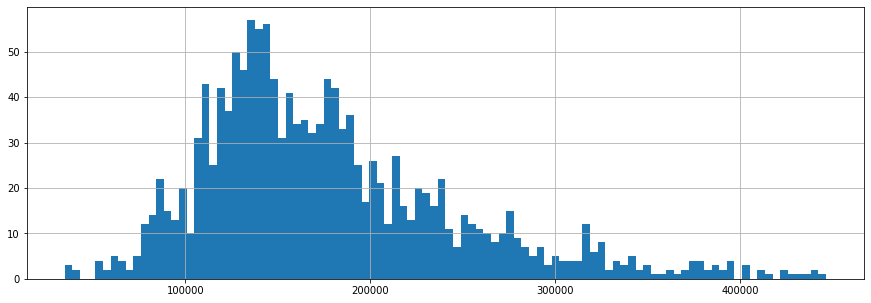

In [5]:
train_raw['SalePrice'].hist(bins=100, figsize=(15, 5))

In [6]:
bins = [110000, 200000]
groups = train_raw.groupby(np.digitize(train_raw['SalePrice'], bins))

groups.mean() 

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,700.222857,56.981250,7336.605714,4.485714,5.234286,1939.874286,1965.274286,24.405714,166.251429,17.674286,460.577143,644.502857,855.262857,181.651429,12.274286,1049.188571,0.205714,0.017143,1.131429,0.108571,2.394286,1.108571,5.365714,0.125714,1954.976190,0.971429,262.182857,33.348571,20.960000,41.702857,0.000000,0.685714,0.000000,47.622857,6.177143,2007.960000,89640.748571
1,752.974118,67.296784,9423.358824,5.716471,5.742353,1967.136471,1981.649412,72.722550,405.251765,52.887059,514.607059,972.745882,1077.727059,286.584706,5.208235,1369.520000,0.395294,0.077647,1.442353,0.361176,2.870588,1.052941,6.195294,0.530588,1974.040244,1.630588,430.322353,81.703529,36.112941,22.296471,3.256471,15.175294,2.004706,53.129412,6.234118,2007.801176,151646.784706
2,694.971496,80.508721,13737.361045,7.429929,5.387173,1991.843230,1998.881235,185.151079,612.106888,46.023753,707.605701,1365.736342,1431.527316,519.422803,3.292162,1954.242280,0.570071,0.033254,1.961995,0.524941,3.045131,1.009501,7.524941,0.952494,1993.496420,2.332542,634.327791,141.505938,76.156770,13.783848,5.249406,18.973872,4.201900,23.752969,6.593824,2007.783848,265424.204276


In [7]:
groups.nunique()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,175,13,4,40,135,2,2,3,4,1,4,3,13,6,4,5,8,7,8,60,41,5,2,13,15,3,19,3,4,5,3,3,4,6,67,5,12,124,103,5,5,2,5,126,47,7,133,3,2,3,3,6,3,4,10,6,3,3,6,61,3,4,64,4,3,3,34,36,44,1,2,1,0,3,2,10,12,5,5,5,97
1,850,15,5,89,627,2,2,4,4,2,5,3,25,9,7,5,8,7,7,105,61,6,7,10,14,4,191,4,4,6,4,3,4,6,420,6,104,530,449,4,4,2,4,488,237,15,524,4,3,4,3,7,4,4,10,7,4,5,6,94,3,5,259,5,5,3,193,132,84,13,55,4,2,4,3,14,12,5,8,6,293
2,421,11,4,91,390,2,2,4,4,1,5,3,19,7,3,5,7,7,8,74,43,6,5,11,13,4,199,4,3,5,4,3,4,6,260,6,35,350,347,2,4,2,2,344,186,4,354,3,2,4,3,8,2,4,10,5,4,4,4,72,3,5,266,3,3,3,145,144,26,10,31,4,3,3,2,8,12,5,8,5,259


## Data Preprocessing

In [8]:
def get_quality_cols(data):
    quality_cols = data.columns[data.isin(['Ex','Po']).any()]  #'Gd', 'TA', 'Fa', 
    return quality_cols

def get_cols_by_type(data):
    colsbytype = {}
    for idx, val in zip(data.dtypes.index, data.dtypes.values):
        if idx == 'SalePrice':
            continue
        val = str(val)
        curr = colsbytype.get(val, set())
        curr.add(idx)
        colsbytype[val] = curr
    for key in colsbytype.keys():
        columns = list(colsbytype[key])
        columns.sort()
        colsbytype[key] = columns
    return colsbytype

def map_quality_values(train,test):
    qual_map = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa': 2, 'Po':1, 'NA':0}
    for data in [train,test]:
        quality_cols = get_quality_cols(data)  
        data[quality_cols] = data[quality_cols].replace(qual_map)
    return train, test

def clean_data(train_raw, test_raw):
    train = train_raw.copy()
    test = test_raw.copy()
    for data in [train, test]:
        colsbytype = get_cols_by_type(data)
        data[colsbytype['object']] = data[colsbytype['object']].fillna('NA')
        data[colsbytype['int64']] = data[colsbytype['int64']].fillna(0)
        data[colsbytype['float64']] = data[colsbytype['float64']].fillna(0.0)
    return train,test


In [20]:
def get_age_info(train,test):
    for data in [train,test]:
        data['age'] = data['YrSold'] - data['YearBuilt'] 
        data['facelift'] = data['YearRemodAdd'] - data['YearBuilt']

        del data['YrSold']
        del data['YearBuilt']
        del data['YearRemodAdd']

    return train, test    

def get_baths(train, test):
    for data in [train,test]:
        data['bathrooms'] = data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])
        
        del data['FullBath']
        del data['HalfBath']
        del data['BsmtFullBath'] 
        del data['BsmtHalfBath']
    
    return train, test

def get_size(train,test):
    for data in [train,test]:
        data['has_2ndFl'] = data.apply(lambda row: 1 if row['2ndFlrSF'] > 1 else 0, axis=1)
        del data["1stFlrSF"]
        del data["2ndFlrSF"]
    return train, test 
    
def expand_dummies(train, test):
    cols = get_cols_by_type(train)
    for data in [train,test]:
        for col in cols['object']:
            vals = set(train[col].unique())
            vals.update(test[col].unique())
            for val in vals:
                data[col + "_" + val] = data.apply(lambda row: 1 if row[col] == val else 0, axis=1)
    for col in cols['object']:
        for data in [train,test]:
            del data[col]
    return train, test

In [21]:
def scale_data(train, test, cols):
    cols = list(train.columns)
    cols.remove("Id")
    cols.remove("SalePrice")
    all_cols = get_cols_by_type(test[cols])
    num_cols = all_cols['int64']
    num_cols.extend(all_cols['float64'])

    scaler = MinMaxScaler()
    X_train = train.copy()
    X_test = test.copy()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    return X_train, X_test


In [22]:
train, test = clean_data(train_raw, test_raw)
train, test = map_quality_values(train,test)
train, test = get_age_info(train, test)
train, test = get_baths(train, test)
train, test = get_size(train, test)
train, test = expand_dummies(train, test)
train, test = scale_data(train, test, list(train.columns))

print("Any Nulls: ", train.isnull().values.any(), test.isnull().values.any())
print(len(train.columns), len(test.columns) )
train.head()

Any Nulls:  False False
282 281


,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,SalePrice,age,facelift,bathrooms,has_2ndFl,Alley_NA,Alley_Grvl,Alley_Pave,BldgType_Duplex,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_2fmCon,BsmtExposure_NA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_GLQ,BsmtFinType1_NA,BsmtFinType1_ALQ,BsmtFinType1_Unf,BsmtFinType1_BLQ,BsmtFinType1_Rec,BsmtFinType1_LwQ,BsmtFinType2_NA,BsmtFinType2_GLQ,BsmtFinType2_ALQ,BsmtFinType2_Unf,BsmtFinType2_BLQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,CentralAir_N,CentralAir_Y,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_Norm,Condition1_RRNe,Condition1_PosN,Condition1_Feedr,Condition1_Artery,Condition1_RRAe,Condition2_RRNn,Condition2_RRAn,Condition2_Norm,Condition2_RRAe,Condition2_PosN,Condition2_Feedr,Condition2_Artery,Condition2_PosA,Electrical_FuseP,Electrical_NA,Electrical_Mix,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Exterior1st_NA,Exterior1st_BrkComm,Exterior1st_CemntBd,Exterior1st_CBlock,Exterior1st_WdShing,Exterior1st_VinylSd,Exterior1st_AsbShng,Exterior1st_ImStucc,Exterior1st_Stone,Exterior1st_BrkFace,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_Wd Sdng,Exterior1st_AsphShn,Exterior2nd_NA,Exterior2nd_CBlock,Exterior2nd_VinylSd,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Stone,Exterior2nd_MetalSd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_HdBoard,Exterior2nd_Wd Shng,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_AsphShn,Exterior2nd_Other,Fence_NA,Fence_MnPrv,Fence_MnWw,Fence_GdWo,Fence_GdPrv,Foundation_CBlock,Foundation_Slab,Foundation_Stone,Foundation_BrkTil,Foundation_PConc,Foundation_Wood,Functional_NA,Functional_Min1,Functional_Sev,Functional_Maj2,Functional_Typ,Functional_Min2,Functional_Maj1,Functional_Mod,GarageFinish_RFn,GarageFinish_NA,GarageFinish_Unf,GarageFinish_Fin,GarageType_Basment,GarageType_NA,GarageType_2Types,GarageType_Detchd,GarageType_CarPort,GarageType_Attchd,GarageType_BuiltIn,Heating_Grav,Heating_Wall,Heating_Floor,Heating_OthW,Heating_GasW,Heating_GasA,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Fin,HouseStyle_2.5Fin,HouseStyle_SLvl,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_1Story,LandContour_Low,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandSlope_Sev,LandSlope_Gtl,LandSlope_Mod,LotConfig_CulDSac,LotConfig_FR3,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotShape_IR2,LotShape_Reg,LotShape_IR3,LotShape_IR1,MSSubClass_75,MSSubClass_150,MSSubClass_90,MSSubClass_70,MSSubClass_60,MSSubClass_30,MSSubClass_80,MSSubClass_85,MSSubClass_190,MSSubClass_160,MSSubClass_20,MSSubClass_180,MSSubClass_120,MSSubClass_45,MSSubClass_50,MSSubClass_40,MSZoning_NA,MSZoning_RM,MSZoning_RL,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MasVnrType_NA,MasVnrType_None,MasVnrType_BrkCmn,MasVnrType_Stone,MasVnrType_BrkFace,MiscFeature_NA,MiscFeature_Gar2,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_Othr,Neighborhood_NWAmes,Neighborhood_Veenker,Neighborhood_BrkSide,Neighborhood_SWISU,Neighborhood_Mitchel,Neighborhood_Edwards,Neighborhood_SawyerW,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_OldTown,Neighborhood_Crawfor,Neighborhood_Blmngtn,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_MeadowV,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_Blueste,Neighborhood_Sawyer,Neighborhood_NoRidge,Neighborhood_IDOTRR,Neighborhood_Somerst,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Timber,PavedDrive_N,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_WdShngl,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_Metal,RoofMatl_ClyTile,RoofMatl_Membran,RoofMatl_Roll,RoofStyl

In [23]:
cols = list(train.columns)
cols.remove("Id")
cols.remove("SalePrice")

## Feature Selection

In [24]:
# We will use these functions to select the best features from our data
def select_cols(feature_cols, target, data, k):
    from sklearn.feature_selection import SelectKBest, f_classif

    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(data[feature_cols], data[target]) 

    selected_features = pd.DataFrame(selector.inverse_transform(X_new), index=data.index, columns=feature_cols)
    selected_columns = selected_features.columns[selected_features.var() != 0]
    return selected_columns
    
def find_best_cols(cols, target, data):
    import warnings
    warnings.filterwarnings("ignore")
    state = 1993  
    size = 0.30 
   
    X_train = data[:1000]
    X_valid = data[1000:]
    
    lr = ensemble.GradientBoostingRegressor() #Base Model
    lr.fit(X_train[cols], X_train[target].values.ravel())
    print ("Base Score: ", lr.score(X_train[cols], X_train[target].values.ravel())) # 0.9672992360887501
    best_score = 0
    best_cols = cols
    for k in range(len(cols)//4, len(cols)):
        lr = ensemble.GradientBoostingRegressor()
        curr_cols = select_cols(cols, target, X_train, k)
        lr.fit(X_train[curr_cols], X_train[target].values.ravel())
        os_score = lr.score(X_valid[curr_cols], X_valid[target].values.ravel())
        if os_score > best_score:
            is_score = lr.score(X_train[curr_cols], X_train[target].values.ravel())
            print ("K= ", k, ", IS score: ", is_score, ", OS score: ", os_score) # 0.840628507295174
            best_score = os_score
            best_cols = curr_cols
            
    return best_cols

best_cols = find_best_cols(cols, "SalePrice", train)
best_cols

Base Score:  0.9672992360887501
K=  70 , IS score:  0.9573743558476329 , OS score:  0.868771918749774
K=  72 , IS score:  0.9575960398380022 , OS score:  0.8690059337579064
K=  75 , IS score:  0.9588092945760507 , OS score:  0.8697208220117818
K=  76 , IS score:  0.9570273292619385 , OS score:  0.8701298704635532
K=  77 , IS score:  0.9581788444432099 , OS score:  0.8702392848607564
K=  96 , IS score:  0.9595651508170149 , OS score:  0.8758454988541586
K=  97 , IS score:  0.9598947332137109 , OS score:  0.8763007593224649
K=  100 , IS score:  0.9595210268467487 , OS score:  0.8771682670830312
K=  113 , IS score:  0.9607798222386764 , OS score:  0.8804303003825934
K=  117 , IS score:  0.9637000060518705 , OS score:  0.8902727589105419
K=  118 , IS score:  0.9638691171381326 , OS score:  0.8918121212397562
K=  124 , IS score:  0.9648274308568483 , OS score:  0.8918860497481882
K=  178 , IS score:  0.9667645905651454 , OS score:  0.8930053426509744
K=  179 , IS score:  0.9667645905651454 

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1',
       ...
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleType_ConLw',
       'SaleType_WD', 'SaleType_COD', 'SaleType_Con', 'SaleType_CWD',
       'SaleType_New', 'Street_Grvl', 'Street_Pave'],
      dtype='object', length=179)

In [25]:
print(len(best_cols))
print(len(cols))
cols = best_cols

179
280


In [30]:
train[cols].head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,3SsnPorch,MiscVal,MoSold,age,facelift,bathrooms,has_2ndFl,Alley_NA,Alley_Pave,BldgType_Duplex,BldgType_1Fam,BldgType_TwnhsE,BsmtExposure_NA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_GLQ,BsmtFinType1_NA,BsmtFinType1_Unf,BsmtFinType2_NA,BsmtFinType2_GLQ,BsmtFinType2_ALQ,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,Condition1_RRAn,Condition1_Artery,Condition2_RRNn,Condition2_RRAn,Condition2_Norm,Condition2_PosN,Condition2_PosA,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_FuseA,Exterior1st_CemntBd,Exterior1st_VinylSd,Exterior1st_BrkFace,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior2nd_VinylSd,Exterior2nd_CmentBd,Exterior2nd_Stone,Exterior2nd_MetalSd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_Wd Sdng,Exterior2nd_Other,Fence_GdWo,Foundation_CBlock,Foundation_Slab,Foundation_Stone,Foundation_BrkTil,Foundation_PConc,Functional_Typ,Functional_Maj1,Functional_Mod,GarageFinish_RFn,GarageFinish_NA,GarageFinish_Unf,GarageFinish_Fin,GarageType_Basment,GarageType_NA,GarageType_Detchd,GarageType_Attchd,GarageType_BuiltIn,Heating_Grav,Heating_Wall,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Fin,HouseStyle_2.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_1Story,LandContour_Low,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandSlope_Sev,LandSlope_Gtl,LandSlope_Mod,LotConfig_CulDSac,LotConfig_FR3,LotConfig_Inside,LotConfig_Corner,LotShape_IR2,LotShape_Reg,LotShape_IR3,LotShape_IR1,MSSubClass_75,MSSubClass_90,MSSubClass_70,MSSubClass_60,MSSubClass_30,MSSubClass_85,MSSubClass_160,MSSubClass_20,MSSubClass_180,MSSubClass_120,MSSubClass_45,MSZoning_RM,MSZoning_RL,MSZoning_C (all),MSZoning_FV,MasVnrType_NA,MasVnrType_None,MasVnrType_BrkCmn,MasVnrType_Stone,MasVnrType_BrkFace,MiscFeature_NA,MiscFeature_Gar2,MiscFeature_Shed,MiscFeature_Othr,Neighborhood_Veenker,Neighborhood_BrkSide,Neighborhood_Mitchel,Neighborhood_SawyerW,Neighborhood_BrDale,Neighborhood_OldTown,Neighborhood_Crawfor,Neighborhood_Blmngtn,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_NoRidge,Neighborhood_IDOTRR,Neighborhood_Somerst,Neighborhood_CollgCr,Neighborhood_Timber,PavedDrive_N,PavedDrive_Y,RoofMatl_Membran,RoofStyle_Hip,RoofStyle_Gable,RoofStyle_Gambrel,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial,SaleType_ConLw,SaleType_WD,SaleType_COD,SaleType_Con,SaleType_CWD,SaleType_New,Street_Grvl,Street_Pave
0,1.0,0.033420,0.666667,0.500,1.0,0.666667,0.5,0.8,0.75,0.125089,0.0,0.064212,0.140098,1.00,0.259231,0.375,0.333333,0.666667,0.500000,0.000000,0.0,1.0,0.50,0.386460,0.6,0.6,0.000000,0.111517,0.0,0.0,0.090909,0.036765,0.000000,0.5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.038795,0.555556,0.875,1.0,0.333333,0.5,0.8,0.75,0.173281,0.0,0.121575,0.206547,1.00,0.174830,0.375,0.333333,0.333333,0.333333,0.333333,0.6,1.0,0.50,0.324401,0.6,0.6,0.347725,0.000000,0.0,0.0,0.363636,0.227941,0.000000,0.3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

## Modeling

In [35]:
# We will use this function to get the best model 
def get_tuned_model(estimator, param_grid, scoring, X_train, Y_train):
    from sklearn.model_selection import GridSearchCV

    grid = GridSearchCV(estimator = estimator, 
                       param_grid = param_grid,
                       scoring = scoring,
                       cv=3,
                       n_jobs= -1
                      )

    tuned = grid.fit(X_train, Y_train)

    print ("Best score: ", tuned.best_score_) # 0.840628507295174
    print ("Best params: ", tuned.best_params_)
    print ("IS Score: ", tuned.score(X_train, Y_train)) # 0.8698092031425365
    
    return tuned


In [44]:
param_grid = { 
    "learning_rate":  [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
    "n_estimators": [500]
}

gbc = ensemble.GradientBoostingRegressor()
gbc_tuned = get_tuned_model(gbc, param_grid, "r2", train[cols], train[["SalePrice"]].values.ravel())

Best score:  0.9026101211901117
Best params:  {'learning_rate': 0.1, 'n_estimators': 500}
IS Score:  0.9895093357338497


In [45]:
# We will use this to save our results 
def save_results(model, data, ids):
    pred_test = model.predict(data) # Predict values for data
    test_res = ids.copy()
    test_res["SalePrice"] = pred_test
    test_res.to_csv("my_predictions.csv", index=False)
    return test_res

In [52]:
results = save_results(gbc_tuned, test[cols], test[['Id']])
results.head()

,Id,SalePrice
0,1461,129502.808540
1,1462,169504.847221
2,1463,189205.816381
3,1464,187510.208908
4,1465,174864.372752


## Extra
### Feature Importance

In [53]:
gbr = ensemble.GradientBoostingRegressor(**gbc_tuned.best_params_)
reg = gbr.fit(train[cols], train["SalePrice"])

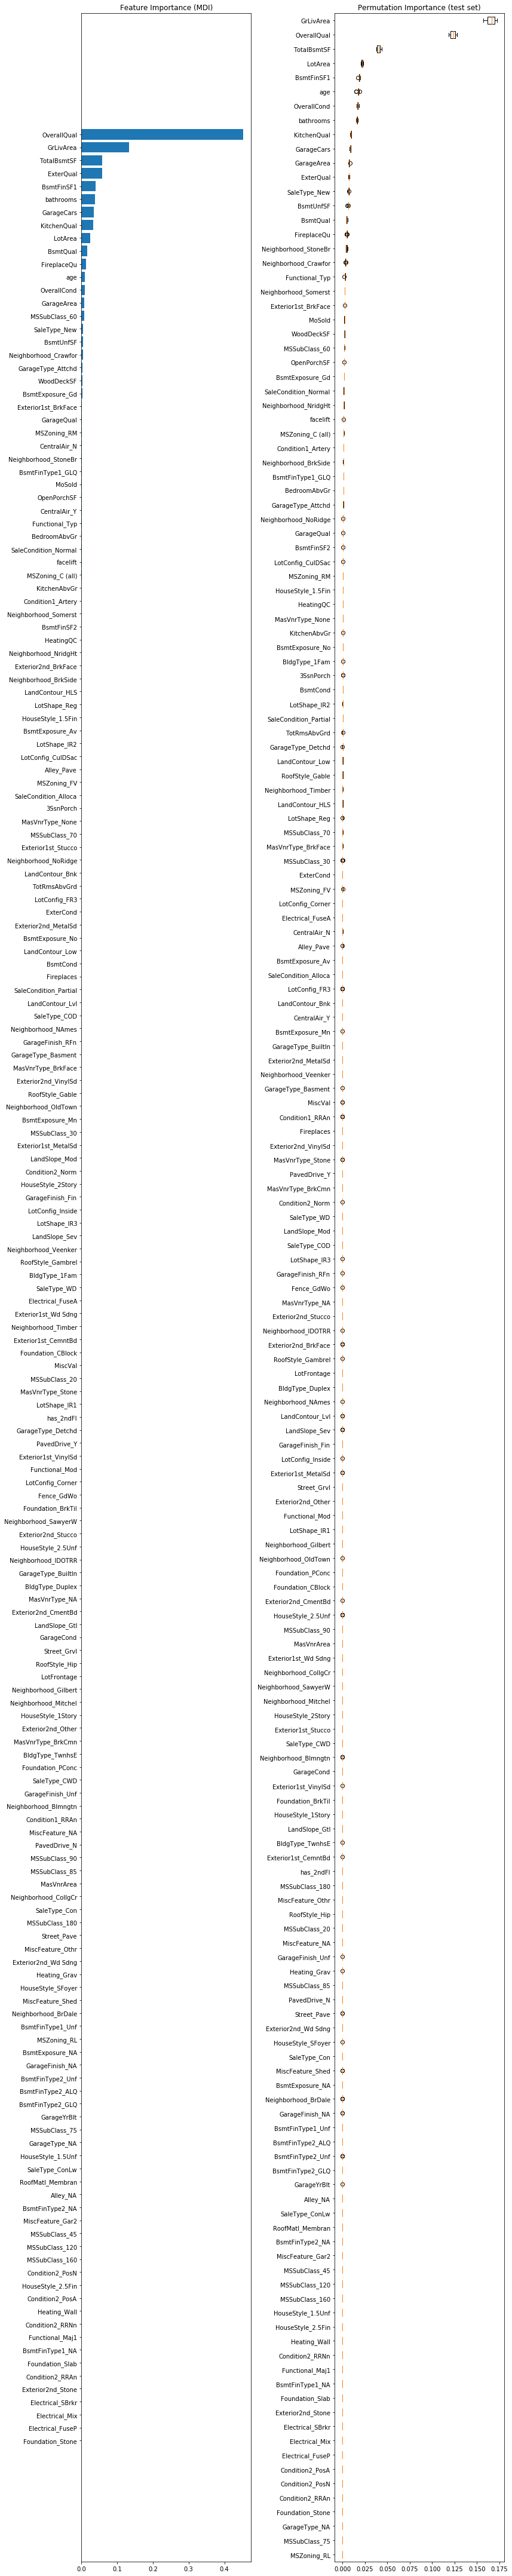

In [54]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 60))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, train[cols], train[['SalePrice']].values.ravel(), n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, 
            labels=np.array(cols)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Viz

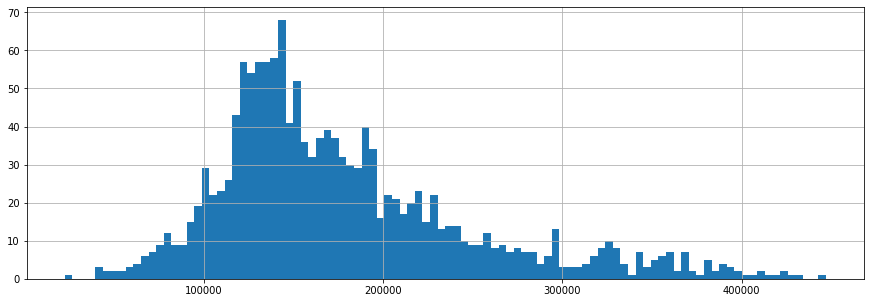

In [55]:
results['SalePrice'].hist(bins=100, figsize=(15, 5))

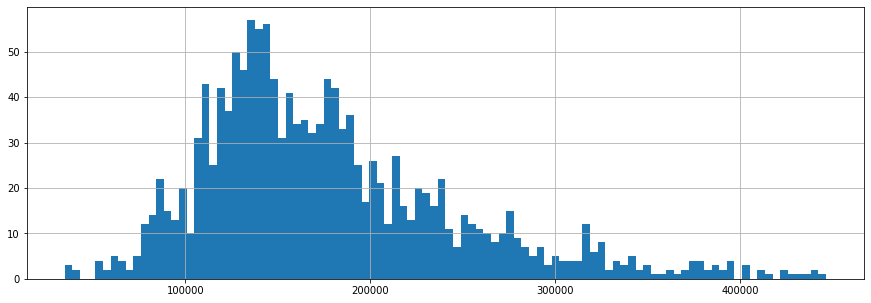

In [56]:
train_raw['SalePrice'].hist(bins=100, figsize=(15, 5))